## イントロダクション

コンペティションのタイトルからは分かりにくいのですが、
今回のコンペティションの目的は**「広告がクリックされたあとにダウンロードされるかされないか」**を予測することです。

不正クリックかどうかを検知するのに、なぜ広告がクリックされた後アプリがダウンロードされるかを調べる必要があるのでしょうか？

まずドメイン知識として、「なぜ不正クリックをするのか」を調べました。

不正クリックを行って利益を得ようとする人は大きく「競合アプリの開発者」と「広告ネットワーク会社」に分かれます。

1. 競合アプリの開発者
    - 広告出稿主は広告費として一日の上限金額を設定しています。１クリックごとに金額が発生するため、一定回数以上クリックされるとその広告は表示されなくなります。これを利用して競合アプリの広告を表示させなくすることで自分たちのアプリの広告を表示させようとしています。
1. 広告ネットワーク会社
    - 広告ネットワーク会社は広告出稿主からクリックごとに料金をもらえます。そのため不正クリックでクリックを水増しすることで利益を得ようとします。



>[広告業界の裏事情](http://www.china-webby.com/%E7%99%BE%E5%BA%A6sem%E5%BA%83%E5%91%8A%E3%81%AE%E8%A3%8F%E4%BA%8B%E6%83%85%EF%BC%9A%E4%B8%8D%E6%AD%A3%E3%82%AF%E3%83%AA%E3%83%83%E3%82%AF/)


>[不正業者の実態](https://www.gizmodo.jp/2017/06/thai-click-fraud-farm-busted-using-wall-of-iphones.html)

概要でも説明がありましたが、不正業者はなるべく多くのスマートフォンを使って膨大なクリックを発生させたいので、広告をクリックしてもアプリをダウンロードすることは決してありません。

つまり**広告をクリックしたあとアプリをダウンロードされないクリックは不正クリック**とみなします。

このことを念頭においてデータを見ていきます。



## 全体の俯瞰
train.csvは約２億件のデータがあるのでまずtrain_sample.csvを見ていきます。

In [33]:
# 必要なモジュールのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [34]:
ls ./competitions/talkingdata-adtracking-fraud-detection/

sample_submission.csv.zip  train.csv.zip
test.csv.zip               train_sample.csv.zip
test_supplement.csv.zip


In [35]:
data_dir_path = './competitions/talkingdata-adtracking-fraud-detection/'

In [36]:
sample_df = pd.read_csv(data_dir_path + 'train_sample.csv.zip')

In [37]:
sample_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


attributed_timeはダウンロードされたときの時間なのでis_attributedが0のものはNanになっています。

In [38]:
sample_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


train_sample.csvのデータは１０万件あり、click_timeとattributed_time以外は数値データで正の数値です。

次に広告がクリックされた後ダウンロードされた件数とされていない件数を見比べてみる。

,is_attributed,count
0,0,99773
1,1,227


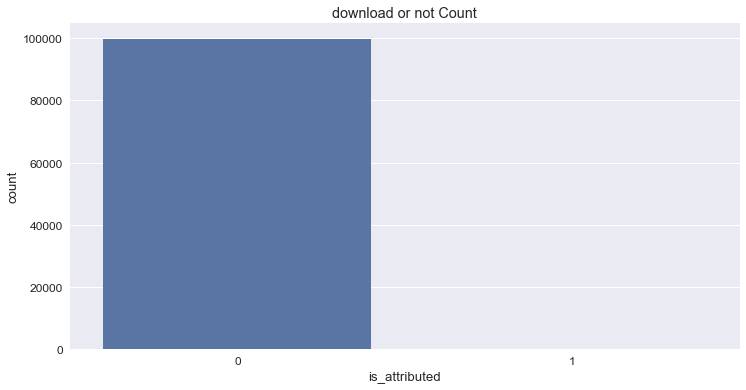

In [39]:
plt.figure(figsize=(12, 6))
click_count = sample_df.groupby('is_attributed', as_index=False)['ip'].count()
click_count = click_count.rename(columns ={'ip':'count'})
sns.barplot(x='is_attributed', y='count', data= click_count);
plt.title('download or not Count');
click_count.head()

クリック後にダウンロードされた数はかなり少なくて実際には227件なので約0.23%しかありません。

次にそれぞれのユニークな値の件数を見てみましょう。

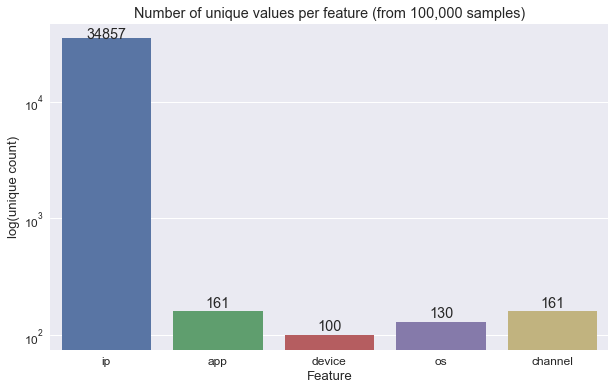

In [40]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(sample_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 100,000 samples)');
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 10,
        uniq,
        ha="center") 

ipアドレスが一番多く、それ以外は100~200に収まっています。

## 時間帯でのクリック数とダウンロード数

①目的であるならば人が寝ている時間に不正クリックが発生しているかもしれません。
click_timeを分解して、日、時、分の項目を新しく作成します。
ちなみにデータは2017年11月6日から９日の平日で中国で特別なイベントはありません。

In [41]:
sample_df['click_time_dt']= pd.to_datetime(sample_df['click_time'])
dt= sample_df['click_time_dt'].dt
sample_df['day'] = dt.day.astype('uint8')
sample_df['hour'] = dt.hour.astype('uint8')
sample_df['minute'] = dt.minute.astype('uint8')

アプリをダウンロードしたデータと ダウンロードしていないデータで分けてデータを見てみましょう。

In [42]:
dll_df = sample_df[sample_df['is_attributed'] == 1]
not_dll_df = sample_df[sample_df['is_attributed'] == 0]

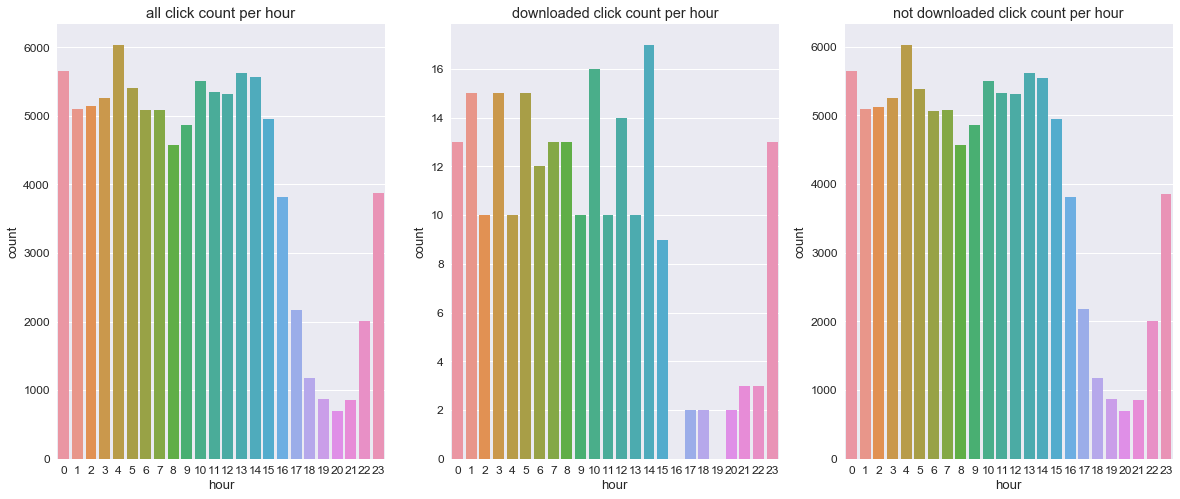

In [75]:
fig ,ax = plt.subplots(1,3, figsize= (20, 8))


sns.countplot(x='hour', data=sample_df, ax=ax[0]);
sns.countplot(x='hour', data=dll_df, order=[i for i in range(24)] , ax=ax[1]);
sns.countplot(x='hour', data=not_dll_df,  ax=ax[2]);
ax[0].set_title('all click count per hour');
ax[1].set_title('downloaded click count per hour');
ax[2].set_title('not downloaded click count per hour');


時間帯ごとの全体のクリック数、ダウンロードされたクリック数、ダウンロードされなかったクリック数をそれぞれプロットしています。
18〜22時あたりがクリック数が共通して落ち込んでいますが、３つのグラフで大きな違いは見られません。


次に時間帯ごとのクリック数に対するダウンロード率をプロットしてみましょう。

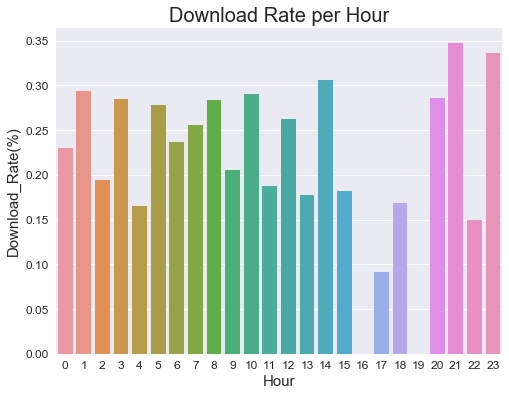

In [67]:
# クリック後のダウンロード率を時間ごとに確認する
count_per_hour = sample_df.groupby('hour', as_index = False).count()
count_per_hour = count_per_hour[['hour', 'app', 'attributed_time']]
count_per_hour = count_per_hour.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
count_per_hour['download_rate'] = count_per_hour['download_count'] / count_per_hour['click_count'] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='hour', y='download_rate', data=count_per_hour);
plt.ylabel('Download_Rate(%)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
ax.set_title('Download Rate per Hour', fontsize = 20);

夕方近辺はダンロード数も落ち込んでいますが、ダウンロード率も落ち込んでいますね。
これはあまり良いグラフではないね。ダウンロード率が小さすぎるので１件でダウンロード率が大きく変わってしまうからね。

コンピュータで自動クリックしているとしたら10分間隔でにクリックが集中するかもしれない。

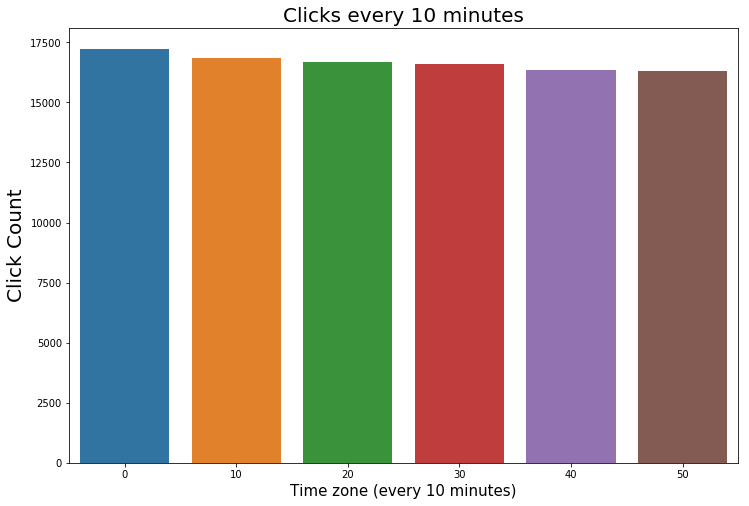

In [55]:
sample_df['minute_band'] = pd.cut(sample_df['minute'], 6)
# 10分幅でクリック数をカウントして表示する
minute_df = sample_df.groupby('minute_band', as_index=False).count().sort_values(by='minute_band', ascending=True) [['minute_band', 'ip']]

rename_dict = {}
minute_band_name = ['0', '10', '20', '30', '40', '50']
for minute_band,col in zip(minute_band_name, minute_df['minute_band']):
    rename_dict[col] = minute_band

minute_df = minute_df.rename(index=rename_dict)

def rename_minute_band(s):
    return rename_dict[s]

minute_df ['minute_band']= minute_df['minute_band'].map(rename_minute_band)

plt.figure(figsize=(12,8))
sns.barplot(x='minute_band', y='ip' ,data=minute_df)
plt.title("Clicks every 10 minutes", fontsize =20)
plt.xlabel('Time zone (every 10 minutes)',fontsize=15)
plt.ylabel('Click Count',fontsize=20)
plt.show()

時間と10分間隔で見てきたけど、顕著な違いは現れなかった。
思った以上に不正業者は巧妙に不正を行っているようだ。


## 各変数の相関関係

次に各変数間の相関関係を見てみよう。

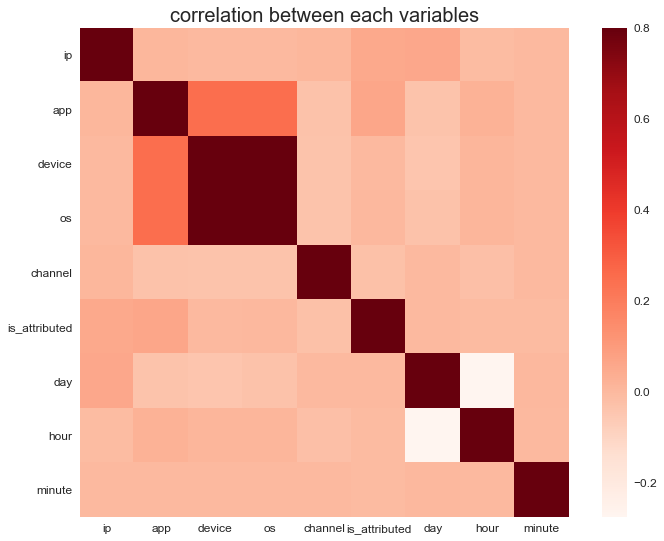

In [94]:
# 相関係数を見てみる
corrmat = sample_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='Reds',vmax=.8, square=True, ax=ax);
ax.set_title("correlation between each variables", fontsize= 20);

OS、デバイス、アプリに強い相関があるようだけど、目的変数であるis_attritutedと相関が強いものが見当たらない。
強いて言えばIP、アプリくらいかな。

次に[不正業者の実態](https://www.gizmodo.jp/2017/06/thai-click-fraud-farm-busted-using-wall-of-iphones.html)を見て、次の推測は次の4つです。

1. 同じipアドレスで大量にクリックしていないか
1.  同じデバイス、OSでクリックしていないか
1. 競合アプリ開発者からの不正で特定のアプリでクリック数が増えていないか
1. 広告パブリッシャーからの不正で特定のチャネルでクリック数が増えていないか

## 1. 同じipアドレスで大量クリックしているか

count    100000.000000
mean      91255.879670
std       69835.553661
min           9.000000
25%       40552.000000
50%       79827.000000
75%      118252.000000
max      364757.000000
Name: ip, dtype: float64


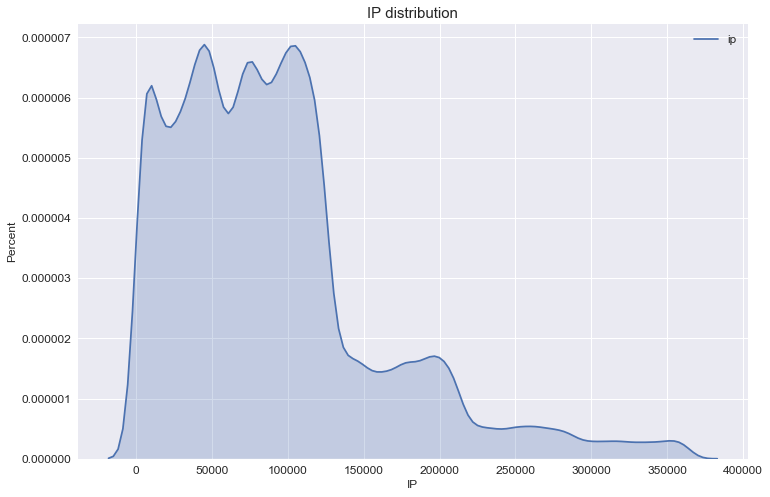

In [115]:
# ipアドレスの分布を確認する。
print(sample_df['ip'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['ip'], shade=True)
plt.title('IP distribution', fontsize = 15)
plt.xlabel('IP', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

0から１００００あたりに集中して分布しています。
本物のipアドレス（192.102.10.52)であれば近い場所にあるなどの情報が分かりますが、残念ながらこのデータのipアドレスはエンコードされてしまっているのでipアドレスの数値に意味を見出すことはできません。

次にipアドレスごとの個数をカウントしてみましょう。

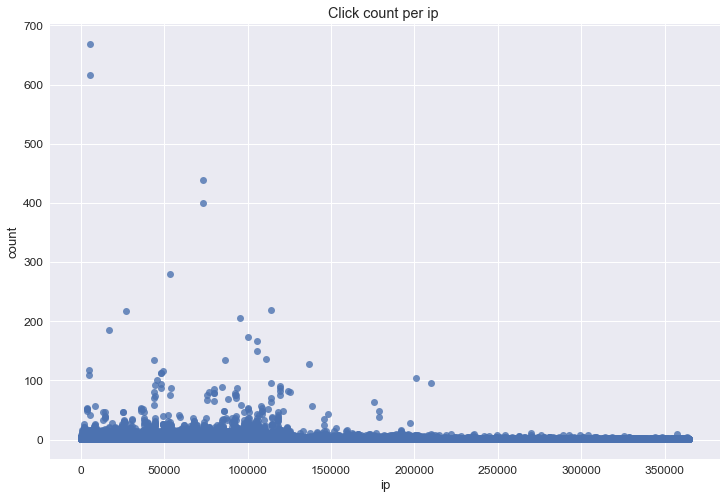

In [100]:
click_ip_count = sample_df.groupby('ip', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'count'})

plt.figure(figsize=(12,8))
sns.regplot(x='ip', y='count', fit_reg=False, data=click_ip_count)
plt.title("Click count per ip ")
plt.show()

続いて、クリック数が20以下のipを除いてもう一度表示してみる。

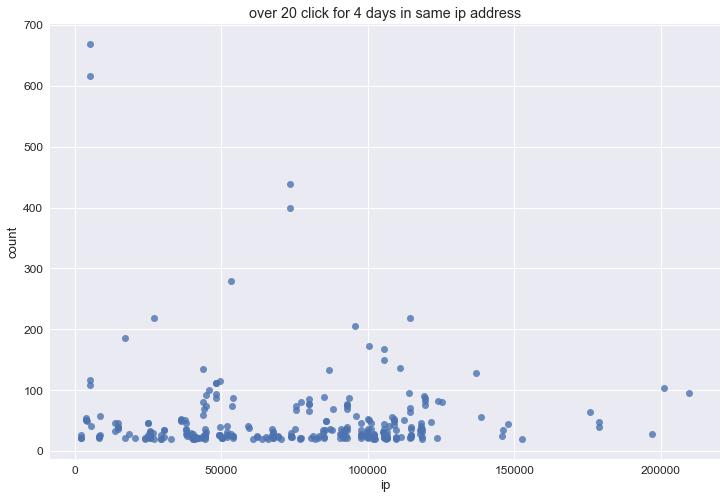

In [99]:
plt.figure(figsize=(12,8))
sns.regplot(x='ip', y='count', fit_reg=False, data=click_ip_count[click_ip_count['count']>19])
plt.title('over 20 click for 4 days in same ip address')
plt.show()

自分がスマートフォンを使っていて４日間で広告を20回以上タップすることはほとんどない。
ここにプロットされたものは不正クリックかもしれない。

もう少しipアドレス視点で分析します。
同一ipアドレスでのクリック数が多いものを上位10並べてみます。

In [175]:
ip_click_ranking = sample_df.groupby('ip', as_index = False).count().sort_values(by = 'app', ascending=False)
ip_click_ranking = ip_click_ranking[['ip', 'app']]
ip_click_ranking = ip_click_ranking.rename(columns={'app':'click_count'})
ip_click_ranking.head(10)

,ip,click_count
926,5348,669
918,5314,616
12833,73487,439
12839,73516,399
9385,53454,280
20021,114276,219
4639,26995,218
16703,95766,205
2990,17149,186
17488,100275,173


試しに一番クリック数の多いip「5348番」のクリック時間を見てみよう。

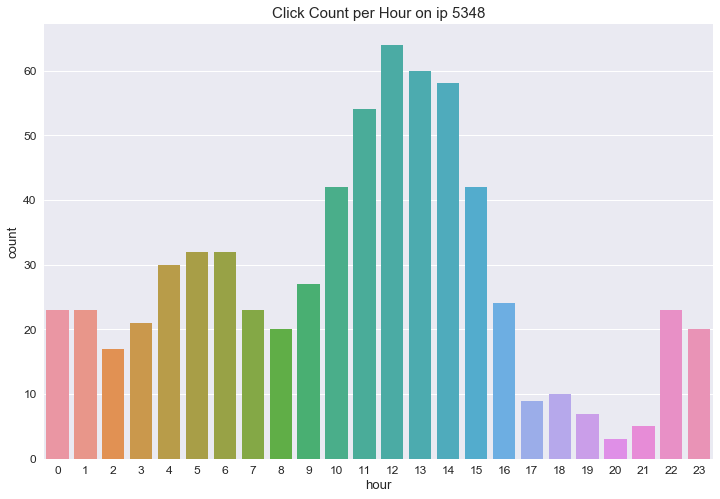

In [160]:
sample_df[sample_df['ip'] == 5348].sort_values(by='click_time', ascending=True).head(20)

plt.figure(figsize=(12,8))
sns.countplot(x='hour', data=sample_df[sample_df['ip'] == 5348]);
plt.title('Click Count per Hour on ip 5348', fontsize=15)
plt.show()

寝ずに一日中クリックしていることが分かる。
これは推測だが同じIPで時間帯で途絶えなければ不正クリックの匂いがします。

またクリックの多いIPのダウンロード数を見てみましょう。

In [89]:
ip_click_download = sample_df.groupby('ip', as_index = False).sum().sort_values(by='app', ascending = False).reset_index()
ip_click_download = ip_click_download[['ip', 'app', 'is_attributed']]
ip_click_download = ip_click_download.rename(columns={'is_attributed': 'download_count', 'app': 'click_count'})

ip_click_download.head(30)

,ip,click_count,download_count
0,5314,10086,3
1,5348,9478,3
2,73487,4809,0
3,73516,4428,0
4,53454,3548,0
5,114276,3243,0
6,26995,3215,0
7,86767,3003,0
8,17149,2993,0
9,105475,2513,0


クリック数が多いipでもダウンロード数が0のipがほとんどです。
ipは不正クリックかの判断に有効そうだ。

## 2.同じデバイス、OSでクリックしていないか

次に同じデバイス、OSでのクリック数を見ていきましょう。

不正業者はなるべく安い端末を大量に持っていて、しかもOSもアップデートせずに使っているかもしれません。

まずデバイスidごとのクリック数を見ていきましょう。

count    100000.000000
mean         21.771250
std         259.667767
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3867.000000
Name: device, dtype: float64


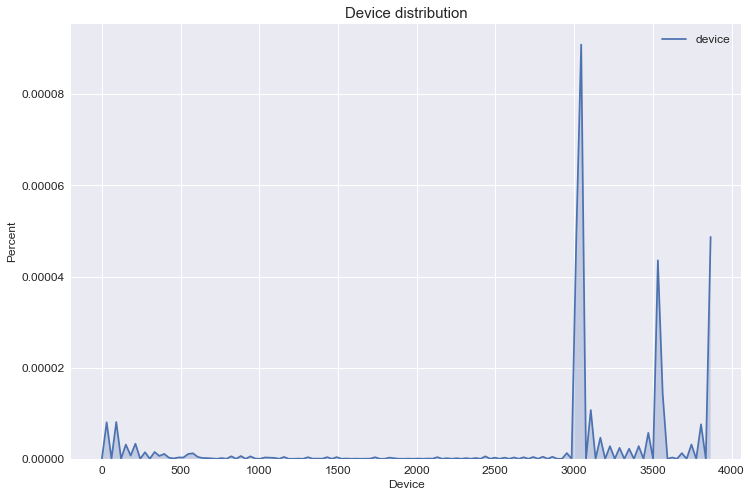

In [132]:
# デバイスの分布を確認する。
print(sample_df['device'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['device'], shade=True)
plt.title('Device distribution', fontsize = 15)
plt.xlabel('Device', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

特定のデバイスでのクリック割合が多いことが分かる。
クリックの多いデバイスの上位１０のダウンロード率を見てみましょう。

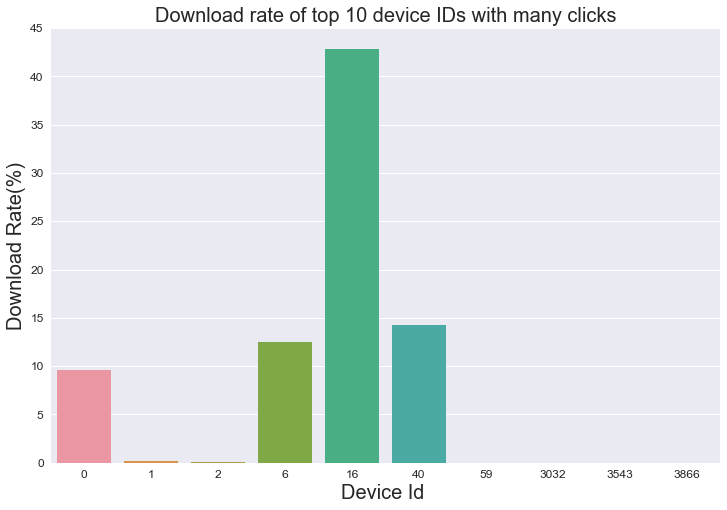

,device,click_count,download_count,download_rate
0,1,94338,146,0.154763
1,2,4345,2,0.046030
2,0,541,52,9.611830
3,3032,371,0,0.000000
4,3543,151,0,0.000000
5,3866,93,0,0.000000
6,59,12,0,0.000000
7,6,8,1,12.500000
8,40,7,1,14.285714
9,16,7,3,42.857143


In [155]:
dll_cnt_device = sample_df.groupby('device', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_device = dll_cnt_device[['device', 'is_attributed']]
dll_cnt_device = dll_cnt_device.rename(columns={'is_attributed': 'download_count'})

click_cnt_device = sample_df.groupby('device', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_device = click_cnt_device[['device', 'app']]
click_cnt_device = click_cnt_device.rename(columns={'app': 'click_count'})

device_click_download_df = pd.merge(click_cnt_device, dll_cnt_device, on='device') 

device_click_download_df['download_rate'] = device_click_download_df['download_count']/ device_click_download_df['click_count'] * 100 




plt.figure(figsize=(12,8))
sns.barplot(x='device', y='download_rate', data=device_click_download_df[:10])
plt.xlabel("Device Id ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 device IDs with many clicks", fontsize=20)
plt.show()

device_click_download_df.head(10)

デバイスIDが0,6,16,40以外のIDはほぼダウンロードがない。もしかしたら不正クリックに使われているかもしれない。

同じようにOSごとのクリック数を見ていきましょう。

count    100000.000000
mean         22.818280
std          55.943136
min           0.000000
25%          13.000000
50%          18.000000
75%          19.000000
max         866.000000
Name: os, dtype: float64


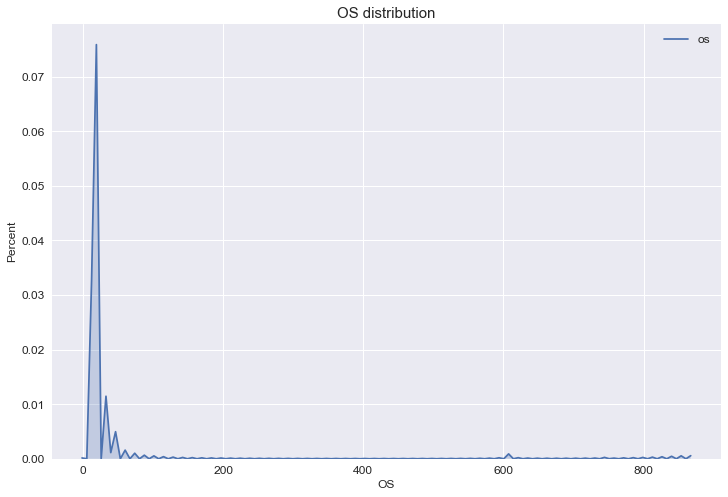

In [151]:
# OSの分布を確認する。
print(sample_df['os'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['os'], shade=True)
plt.title('OS distribution', fontsize = 15)
plt.xlabel('OS', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

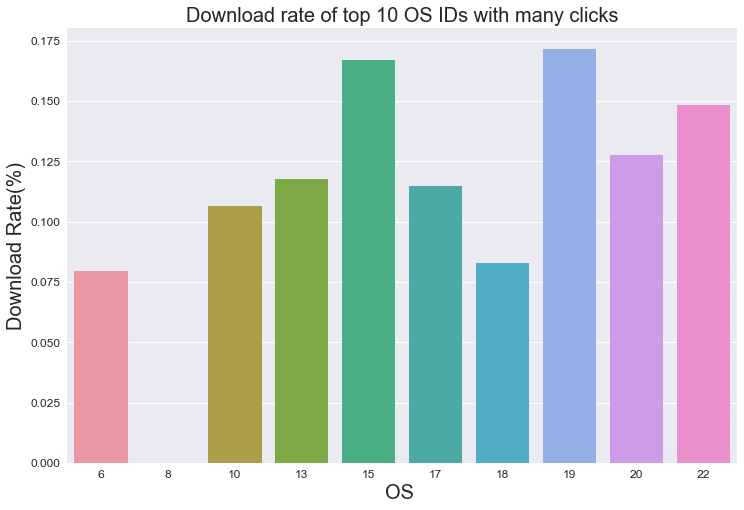

,os,click_count,download_count,download_rate
0,19,23870,41,0.171764
1,13,21223,25,0.117797
2,17,5232,6,0.114679
3,18,4830,4,0.082816
4,22,4039,6,0.148552
5,10,2816,3,0.106534
6,8,2775,0,0.000000
7,6,2520,2,0.079365
8,15,2396,4,0.166945
9,20,2347,3,0.127823


In [156]:
dll_cnt_os = sample_df.groupby('os', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_os = dll_cnt_os[['os', 'is_attributed']]
dll_cnt_os = dll_cnt_os.rename(columns={'is_attributed': 'download_count'})

click_cnt_os = sample_df.groupby('os', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_os = click_cnt_os[['os', 'app']]
click_cnt_os = click_cnt_os.rename(columns={'app': 'click_count'})

os_click_download_df = pd.merge(click_cnt_os, dll_cnt_os, on='os') 

os_click_download_df['download_rate'] = os_click_download_df['download_count']/ os_click_download_df['click_count'] * 100 

os_click_download_df.head(10)

plt.figure(figsize=(12,8))
sns.barplot(x='os', y='download_rate', data=os_click_download_df[:10])
plt.xlabel("OS ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 OS IDs with many clicks", fontsize=20)
plt.show()

os_click_download_df.head(10)

こちらは８番OSだけダウンロード数が0以外は目立った違いは見られない。

## 競合アプリ開発者からの不正で特定のアプリでクリック数が増えていないか

次にアプリごとのクリック数を見てみよう。

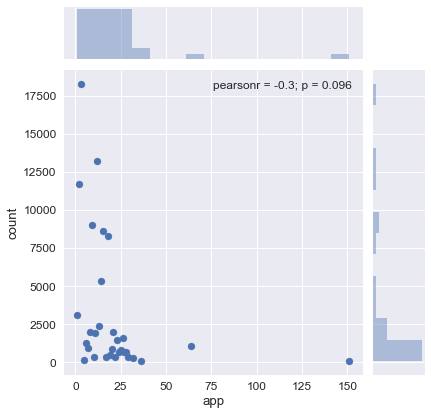

In [79]:
click_ip_count = sample_df.groupby('app', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'count'})
click_ip_count = click_ip_count[click_ip_count['count'] > 100]

plt.figure(figsize=(12,8))
sns.jointplot('app', 'count', data=click_ip_count)
plt.show()

極端にクリックされてるアプリがありますね。
競合アプリ開発者が特定のアプリの広告を表示させないため広告費を使い切らせる目的であるならこの上位のアプリたちはターゲットにされた可能性があります。

## 4. 広告パブリッシャーからの不正で特定のチャネルでクリック数が増えていないか

続いてチャネルも見てみましょう。

広告パブリッシャーが利益を出すために不正クリックをさせているとすると特定のchannelのクリック数が多いというデータが出るはずです。

count    100000.000000
mean        268.832460
std         129.724248
min           3.000000
25%         145.000000
50%         258.000000
75%         379.000000
max         498.000000
Name: channel, dtype: float64


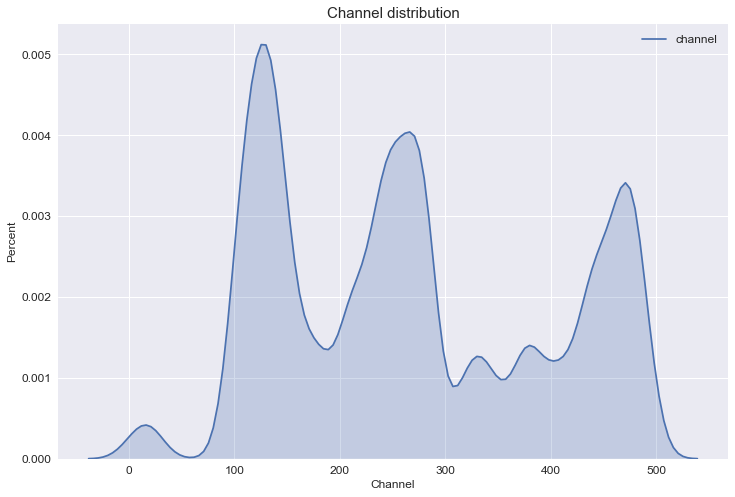

In [162]:
#  チャネルの分布を確認する。
print(sample_df['channel'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['channel'], shade=True)
plt.title('Channel distribution', fontsize = 15)
plt.xlabel('Channel', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

特定のチャネルのクリックが多いがこれだけではただ広告の表示割合が大きいだけかもしれない。

クリック数の多い上位１０のチャネルのクリック数を見てみよう。

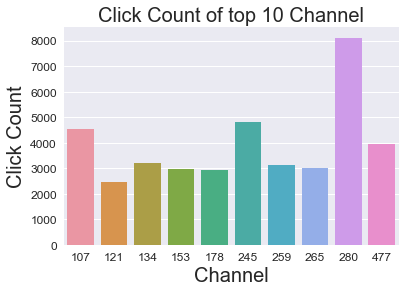

,channel,click_count
77,280,8114
64,245,4802
14,107,4543
146,477,3960
33,134,3224


In [170]:
click_cnt_channel = sample_df.groupby('channel', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_channel = click_cnt_channel[['channel', 'app']]
click_cnt_channel = click_cnt_channel.rename(columns={'app': 'click_count'})

sns.barplot(x='channel', y='click_count', data=click_cnt_channel.sort_values(by='click_count', ascending=False)[:10])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Click Count", fontsize=20)
plt.title("Click Count of top 10 Channel", fontsize=20)
plt.show()

click_cnt_channel.head()


２８０番が多いが、それ以外はほぼ横ばいです。
ここからこの上位１０チャネルのダウンロード率も見てみましょう。

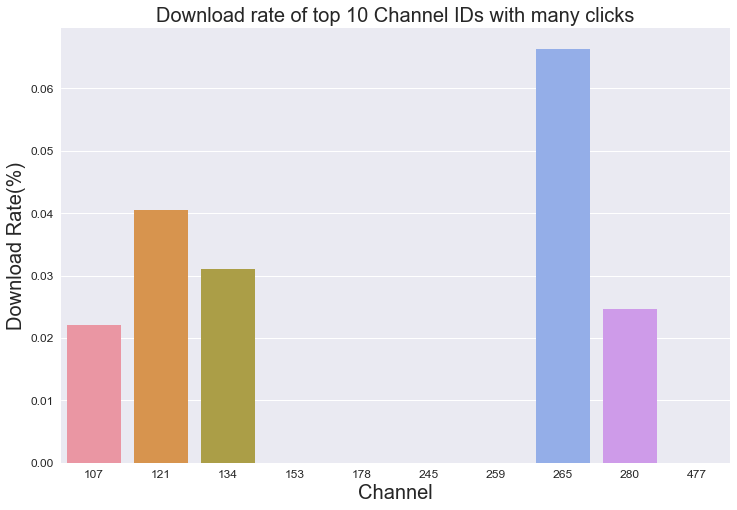

,channel,click_count,download_count,download_rate
0,280,8114,2,0.024649
1,245,4802,0,0.000000
2,107,4543,1,0.022012
3,477,3960,0,0.000000
4,134,3224,1,0.031017
5,259,3130,0,0.000000
6,265,3013,2,0.066379
7,153,2954,0,0.000000
8,178,2936,0,0.000000
9,121,2472,1,0.040453


In [164]:
dll_cnt_channel = sample_df.groupby('channel', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_channel = dll_cnt_channel[['channel', 'is_attributed']]
dll_cnt_channel = dll_cnt_channel.rename(columns={'is_attributed': 'download_count'})



channel_click_download_df = pd.merge(click_cnt_channel, dll_cnt_channel, on='channel') 

channel_click_download_df['download_rate'] = channel_click_download_df['download_count']/ channel_click_download_df['click_count'] * 100 

plt.figure(figsize=(12,8))
sns.barplot(x='channel', y='download_rate', data=channel_click_download_df[:10])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 Channel IDs with many clicks", fontsize=20)
plt.show()

channel_click_download_df.head(10)

クリック数よりも極端で、まったくダウンロードのないチャネルもある。
もしかしたらダウンロード率の低いチャネルは不正業者に不正を依頼しているかもしれません。

## まとめ

- ipアドレスと時間で見ると定期的にクリックしていることが分かる。明らかに普通の人の使い方ではない。
- クリックが多いがダウンロード率が低いデバイスがある。
- 不正も目論む人たち（広告パブリッシャー、競合アプリ開発者）の目的から推測されたチャネルやアプリIDにも不正クリックとの関連性がありそう。

### 反省点

- とにかく時間がかかった。
- 何をプロットするか、そして何をプロットするか決めたあとに実際にプロットをコーディングするのにも時間がかかった。

### 改善点

- EDAは結論を急ぎすぎず、データをいろいろな方法で眺めるつもりでプロットしていく。有用な情報ばかりでなく、「これはあまり関係がなさそうだ」といった情報も１つの情報となる。
- プロットのパターンは決まっているので自分がプロットしたパターンをストックして次に活かす。また他の人のEDAをたくさん読む。


# 質問やコメントは大歓迎です！

